In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
#Constante ip

IP = '101.4.0.1'

#Dataframes

dict_capturas = dict({'usa': '../data/128.112.0.0 (all ips) 05-18-2022 19:07:42.csv',
                      'usa_mean': '../data/128.112.0.0 05-18-2022 19:40:42.csv'})

for captura in dict_capturas.keys():
    dict_capturas[captura] = pd.read_csv(dict_capturas[captura])
    dict_capturas[captura].name = captura

df_usa = dict_capturas['usa']
df_usa_mean = dict_capturas['usa_mean']

def most_frequent(List):
    return max(set(List), key = List.count)

# Camino de ip's

In [56]:
# Diccionario que en cada entrada es un ttl, y en cada una hay una lista con las ips
# que aparecieron en ese salto
dict_ips_for_every_ttl = dict()
dict_ips_for_every_ttl['ttl1'] = []

# Esto lo hago para poder iterar el df
df_usa = df_usa.reset_index()

row_ttl = 1
for index, row in df_usa.iterrows():
    if (row['ttl'] == row_ttl):
        dict_ips_for_every_ttl['ttl'+str(row_ttl)].append(row['ip'])
    else:
        row_ttl = row['ttl']
        dict_ips_for_every_ttl['ttl'+str(row_ttl)] = []
        dict_ips_for_every_ttl['ttl'+str(row_ttl)].append(row['ip'])

most_frequent_ip = dict()
ttl_anterior = 'ttl1'
for ttl in dict_ips_for_every_ttl.keys():
    if (most_frequent(dict_ips_for_every_ttl[ttl]) == most_frequent(dict_ips_for_every_ttl[ttl_anterior]) and most_frequent(dict_ips_for_every_ttl[ttl]) == IP):
        break    
    most_frequent_ip[ttl] = most_frequent(dict_ips_for_every_ttl[ttl])
    ttl_anterior = ttl

# most_frequent_ip es un diccionario que la clave tiene el ttl correspondiente, y en el valor la ip
# que más apareció para ese ttl

# Dataframe nuevo

In [57]:
dict_ttl_tiempos = dict()

row_ttl = 0
for index, row in df_usa.iterrows():
    if (('ttl' + str(row['ttl']) in most_frequent_ip.keys()) and row['ip'] == most_frequent_ip['ttl' + str(row['ttl'])]):
        if (row['ttl'] == row_ttl):
            dict_ttl_tiempos['ttl'+str(row_ttl)].append(row['rtt'])
        else:
            row_ttl = row['ttl']
            dict_ttl_tiempos['ttl'+str(row_ttl)] = []
            dict_ttl_tiempos['ttl'+str(row_ttl)].append(row['rtt'])

ttls = most_frequent_ip.keys()

tiempos = [np.mean(dict_ttl_tiempos[tiempo]) for tiempo in dict_ttl_tiempos.keys()]

tiempos_aux = tiempos.copy()

for i in range(1, len(tiempos)):
    jump = tiempos[i] - tiempos_aux[i-1]
    if jump < 0:
        j = 1
        while i - j > 0 and jump < 0:
            j += 1
            jump = tiempos[i] - tiempos_aux[i-j]
    tiempos[i] = max(jump, 0)

varianza_de_los_tiempos = [np.var(dict_ttl_tiempos[tiempo]) for tiempo in dict_ttl_tiempos.keys()]

df_time = pd.DataFrame(list(zip(ttls, most_frequent_ip.values(),tiempos, tiempos_aux,varianza_de_los_tiempos)),
               columns =['ttls', 'ip', 'tiempo restado', 'tiempo neto', 'varianza'])

df_time

,ttls,ip,tiempo restado,tiempo neto,varianza
0,ttl1,192.168.0.1,64.848353,64.848353,437.773146
1,ttl6,181.96.103.168,0.299881,65.148234,3.803065
2,ttl7,195.22.220.56,6.082908,71.231143,75.537679
3,ttl8,195.22.219.67,25.891352,97.122494,197.454910
4,ttl9,149.3.181.65,1.001215,98.123709,105.474517
5,ttl10,129.250.4.202,25.283869,96.515012,77.432564
6,ttl11,129.250.2.12,112.530563,209.045575,365.987776
7,ttl12,129.250.6.53,106.601898,203.116910,123.186569
8,ttl13,168.143.228.205,103.021065,199.536077,126.287609
9,ttl14,130.156.34.246,5.315868,204.851945,176.301126


# Gráficos

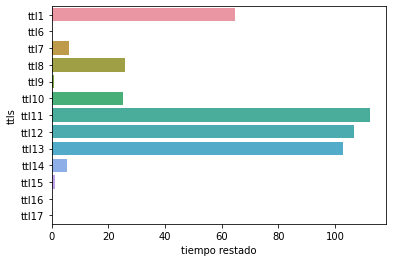

In [58]:
ax = sns.barplot(
    x= df_time['tiempo restado'], 
    y= df_time['ttls'],
    estimator=sum,
    ci=None,
    orient = 'h'
)
fig = ax.get_figure()

In [59]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import requests

locations = []

for ip in most_frequent_ip.values():
    response = requests.get("http://ip-api.com/json/"+ip).json()
    if (response['status'] == 'success'):
        locations.append([response['lat'], response['lon']])
    else:
        locations.append([0, 0])


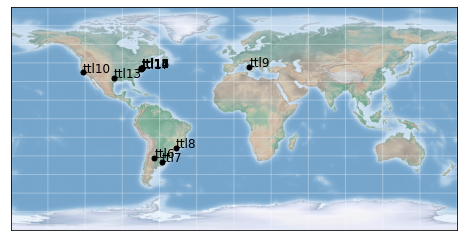

In [61]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)

# Map (long, lat) to (x, y) for plotting
for i in range(len(df_time)):
    if ((locations[i][0] != 0) and (locations[i][1] != 0)):
        x = locations[i][1]
        y = locations[i][0]
        plt.plot(x, y, 'ok', markersize=5)
        plt.text(x, y, df_time.iloc[i].ttls, fontsize=12);

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import requests

locations_with_ttl = []

for ttl, ip in most_frequent_ip.items():
    response = requests.get("http://ip-api.com/json/"+ip).json()
    if (response['status'] == 'success'):
        locations_with_ttl.append([ttl, response['lat'], response['lon']])

df_ubication = pd.DataFrame(locations_with_ttl, columns=["ttl", "Latitude", "Longitude"])
df_ubication

,ttl,Latitude,Longitude
0,ttl6,-31.3183,-64.1625
1,ttl7,-34.6037,-58.3816
2,ttl8,-23.5558,-46.6396
3,ttl9,41.8645,12.4965
4,ttl10,37.3382,-121.8860
5,ttl11,40.7357,-74.1724
6,ttl12,40.7357,-74.1724
7,ttl13,32.7767,-96.7970
8,ttl14,40.9129,-74.1627
9,ttl15,41.0287,-74.6429


In [63]:
import plotly.express as px

fig = px.line_geo(df_ubication, 
                     # longitude is taken from the df["lon"] columns and latitude from df["lat"]
                     lon="Longitude", 
                     lat="Latitude", 
                     # choose the map chart's projection
                     projection="natural earth",
                     markers=True,
                     hover_name = "ttl",
                     )
fig.update_traces(marker=dict(size=5, color="blue"))
fig.update_geos(fitbounds="locations", showcountries = True)

### Punto Opcional

In [64]:
import scipy.stats

def get_thompson_for_n(n):
    alpha = 0.05
    qt = scipy.stats.t.ppf(q = 1 - alpha/2, df = n-2)
    thompson = (qt * (n - 1)) / (np.sqrt(n) * np.sqrt(n - 2 + qt**2))
    return thompson

def find_outliers(df):
    df = df.copy()
    df["outlier"] = False
    df["rtt_deviations"] = 0
    
    while len(df[df["outlier"] == False]) != 0:
        df_without_outliers = df[df["outlier"] == False]
        rtts = df_without_outliers["tiempo restado"]
        df_without_outliers["rtt_deviations"] = abs(rtts - rtts.mean())
        std = rtts.std()
        thompson = get_thompson_for_n(len(df_without_outliers))
        if max(df_without_outliers["rtt_deviations"]) > thompson * std:
            ttl_outlier = df_without_outliers.loc[df_without_outliers["rtt_deviations"].idxmax()]["ttls"]
            #df.at[df.loc[df["ttls"] == ttl_outlier].index[0], "outlier"] = True
            df.loc[df["ttls"] == str(ttl_outlier), "outlier"] = True
        else:
            break
    
    df.drop("rtt_deviations", axis=1, inplace=True)
    return df

df_with_outliers = find_outliers(df_time)
print(df_with_outliers)

     ttls               ip  tiempo restado  tiempo neto    varianza  outlier
0    ttl1      192.168.0.1       64.848353    64.848353  437.773146    False
1    ttl6   181.96.103.168        0.299881    65.148234    3.803065    False
2    ttl7    195.22.220.56        6.082908    71.231143   75.537679    False
3    ttl8    195.22.219.67       25.891352    97.122494  197.454910    False
4    ttl9     149.3.181.65        1.001215    98.123709  105.474517    False
5   ttl10    129.250.4.202       25.283869    96.515012   77.432564    False
6   ttl11     129.250.2.12      112.530563   209.045575  365.987776    False
7   ttl12     129.250.6.53      106.601898   203.116910  123.186569    False
8   ttl13  168.143.228.205      103.021065   199.536077  126.287609    False
9   ttl14   130.156.34.246        5.315868   204.851945  176.301126    False
10  ttl15   130.156.251.50        1.335684   200.871762  121.082564    False
11  ttl16   204.153.48.254        0.121935   199.658012  135.196906    False

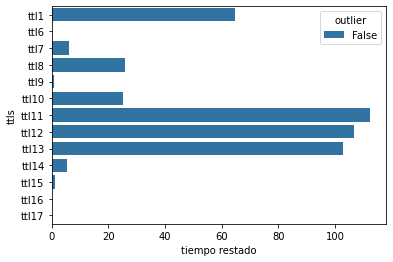

In [65]:
ax = sns.barplot(
    x= df_with_outliers['tiempo restado'], 
    y= df_with_outliers['ttls'],
    estimator=sum,
    ci=None,
    orient = 'h',
    hue=df_with_outliers['outlier']
)
fig = ax.get_figure()

In [66]:
df_ubication_with_outlier = df_ubication.merge(df_with_outliers[["ttls", "outlier"]], left_on="ttl", right_on="ttls")
df_ubication_with_outlier

,ttl,Latitude,Longitude,ttls,outlier
0,ttl6,-31.3183,-64.1625,ttl6,False
1,ttl7,-34.6037,-58.3816,ttl7,False
2,ttl8,-23.5558,-46.6396,ttl8,False
3,ttl9,41.8645,12.4965,ttl9,False
4,ttl10,37.3382,-121.8860,ttl10,False
5,ttl11,40.7357,-74.1724,ttl11,False
6,ttl12,40.7357,-74.1724,ttl12,False
7,ttl13,32.7767,-96.7970,ttl13,False
8,ttl14,40.9129,-74.1627,ttl14,False
9,ttl15,41.0287,-74.6429,ttl15,False


In [67]:
df_ubication_with_outlier["color"] = "blue"
df_ubication_with_outlier["markersize"] = 7
df_ubication_with_outlier["markersymbol"] = "circle"
def format_outliers(row):
    if row["outlier"]:
        row["color"] = "red"
        row["markersize"] = 10
        row["markersymbol"] = "diamond"
    return row
df_ubication_with_outlier = df_ubication_with_outlier.apply(format_outliers, axis=1)

In [68]:
import plotly.express as px

fig = px.line_geo(df_ubication, 
                     # longitude is taken from the df["lon"] columns and latitude from df["lat"]
                     lon="Longitude", 
                     lat="Latitude", 
                     # choose the map chart's projection
                     projection="natural earth",
                     markers=True,
                     hover_name = "ttl",
                     )
fig.update_traces(marker=dict(symbol = df_ubication_with_outlier["markersymbol"], size=df_ubication_with_outlier["markersize"], color=df_ubication_with_outlier["color"]))
fig.update_geos(fitbounds="locations", showcountries = True)